

# Credit Card Fraud Detection
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Things to Learn in this case study
* How to deal with the unbalanced Data
* Precison, Recall or Accuracy - which metric is important
* How to Downsample the data in case there is a significant imbalance

How to enhance performance and achieve the desirable by:
1. Choosing the right metric
2. Modifying the data- Upsample, Downsample


## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2) 
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluate Models](#4.2) 
* [6. Model Tuning](#5)
    * [5.1. Model Tuning-Right Evaluation Metric](#5.1)
    * [5.2. Model Tuning-Balancing the sample](#5.2) 



<a id='0'></a>
# 1. Problem Definition

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.The task is to get forecast the fraud. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.The features are the result of PCA transformation and aren't intuitive as far as their names are concerned.


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [148]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

<a id='1.2'></a>
## 2.2. Loading the Data

In [52]:
# load dataset
dataset = read_csv('creditcard.csv')

In [53]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [149]:
# shape
dataset.shape

(284807, 31)

In [150]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.62,0
1,0.0,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.69,0
2,1.0,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.66,0
3,1.0,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.50,0
4,2.0,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.99,0


In [57]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

As shown in the results above, the entire data type is float, except Class which is integer, and the variable names aren't intuitive.

In [151]:
# describe data
set_option('precision', 3)
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,...,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,284807.000,284807.000
mean,94813.860,3.920e-15,5.688e-16,-8.769e-15,2.782e-15,-1.553e-15,2.011e-15,-1.694e-15,-1.927e-16,-3.137e-15,...,1.537e-16,7.960e-16,5.368e-16,4.458e-15,1.453e-15,1.699e-15,-3.660e-16,-1.206e-16,88.350,0.002
std,47488.146,1.959e+00,1.651e+00,1.516e+00,1.416e+00,1.380e+00,1.332e+00,1.237e+00,1.194e+00,1.099e+00,...,7.345e-01,7.257e-01,6.245e-01,6.056e-01,5.213e-01,4.822e-01,4.036e-01,3.301e-01,250.120,0.042
min,0.000,-5.641e+01,-7.272e+01,-4.833e+01,-5.683e+00,-1.137e+02,-2.616e+01,-4.356e+01,-7.322e+01,-1.343e+01,...,-3.483e+01,-1.093e+01,-4.481e+01,-2.837e+00,-1.030e+01,-2.605e+00,-2.257e+01,-1.543e+01,0.000,0.000
25%,54201.500,-9.204e-01,-5.985e-01,-8.904e-01,-8.486e-01,-6.916e-01,-7.683e-01,-5.541e-01,-2.086e-01,-6.431e-01,...,-2.284e-01,-5.424e-01,-1.618e-01,-3.546e-01,-3.171e-01,-3.270e-01,-7.084e-02,-5.296e-02,5.600,0.000
50%,84692.000,1.811e-02,6.549e-02,1.798e-01,-1.985e-02,-5.434e-02,-2.742e-01,4.010e-02,2.236e-02,-5.143e-02,...,-2.945e-02,6.782e-03,-1.119e-02,4.098e-02,1.659e-02,-5.214e-02,1.342e-03,1.124e-02,22.000,0.000
75%,139320.500,1.316e+00,8.037e-01,1.027e+00,7.433e-01,6.119e-01,3.986e-01,5.704e-01,3.273e-01,5.971e-01,...,1.864e-01,5.286e-01,1.476e-01,4.395e-01,3.507e-01,2.410e-01,9.105e-02,7.828e-02,77.165,0.000
max,172792.000,2.455e+00,2.206e+01,9.383e+00,1.688e+01,3.480e+01,7.330e+01,1.206e+02,2.001e+01,1.559e+01,...,2.720e+01,1.050e+01,2.253e+01,4.585e+00,7.520e+00,3.517e+00,3.161e+01,3.385e+01,25691.160,1.000


How many are fraud and how many are not fraud ?

In [155]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

<a id='2.2'></a>
## 3.2. Data Visualization

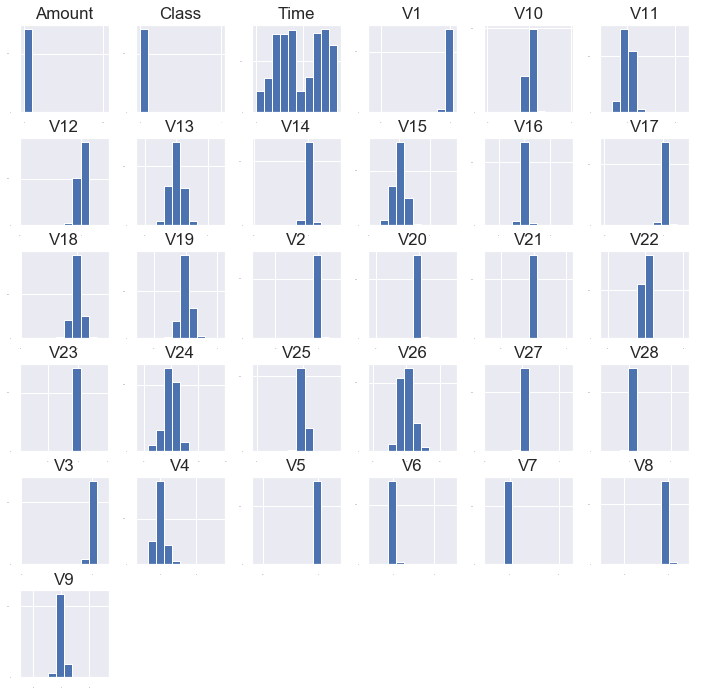

In [156]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Distribution of most of the variables are highly skewed

<a id='3'></a>
## 4. Data Preparation

In [159]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


There is no null in the data, and the data is already in the float format, so there is no need to clean or categorise the data

<a id='3.2'></a>
## 4.2. Feature Selection

In [160]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest( k=10)
bestfeatures
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Specs      Score
17   V17  33979.169
14   V14  28695.548
12   V12  20749.822
10   V10  14057.980
16   V16  11443.349
3     V3  11014.508
7     V7  10349.605
11   V11   6999.355
4     V4   5163.832
18   V18   3584.381


Although some of the features are relevant, feature selection is not given significant preference

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

In [200]:
# split out validation dataset for the end
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
scoring = 'accuracy'

<a id='4.2'></a>
## 5.2. Checking Models and Algorithms

In [64]:
# test options for classification
num_folds = 10
seed = 7

In [162]:
# spot check some basic Classification algorithms
#Given Data is huge, some of the slower classification algorithms are commented
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# #Neural Network
# models.append(('NN', MLPClassifier()))
# # #Ensable Models 
# # Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier()))
# # Bagging methods
# models.append(('RF', RandomForestClassifier()))
# models.append(('ET', ExtraTreesClassifier()))

In [163]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.998942 (0.000229)
LDA: 0.999364 (0.000136)
KNN: 0.998310 (0.000290)
CART: 0.999175 (0.000193)


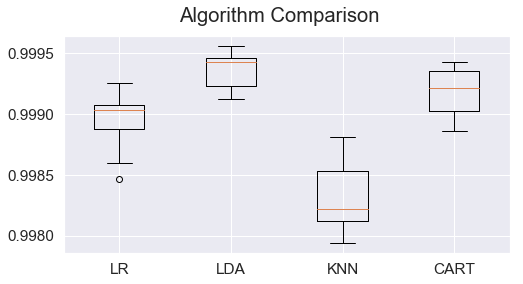

In [164]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

The accuracy is very high, given that accuracy focusses on the overall no fraud case, but lets check how well it predicts the fraud case. Choosing one of the model CART from the results above

In [168]:
# prepare model
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [170]:
# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation)
rescaledValidationX = X_validation
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9992275552122467
[[56839    23]
 [   21    79]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.77      0.79      0.78       100

    accuracy                           1.00     56962
   macro avg       0.89      0.89      0.89     56962
weighted avg       1.00      1.00      1.00     56962



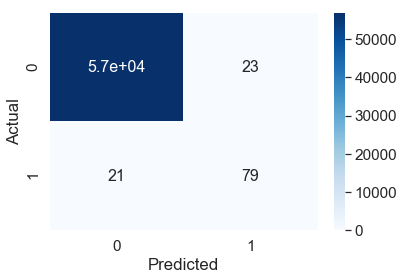

In [179]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

Although results are good, but still 21 out of 100 frauds aren't caught. So, we should focus on recall, which is a metric which minimises false negative. 

<a id='6'></a>
## 6. Model Tuning

<a id='5.1'></a>
## 6.1. Model Tuning by choosing correct evaluation metric
Evaluation Metric recall is selected, which is a metric which minimises false negative.

In [181]:
scoring = 'recall'

In [182]:
# spot check some basic Classification algorithms
#Given Data is huge, some of the slower classification algorithms are commented
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# #Neural Network
# models.append(('NN', MLPClassifier()))
# # #Ensable Models 
# # Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier()))
# # Bagging methods
# models.append(('RF', RandomForestClassifier()))
# models.append(('ET', ExtraTreesClassifier()))

In [183]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.595470 (0.089743)
LDA: 0.758283 (0.045450)
KNN: 0.023882 (0.019671)
CART: 0.735192 (0.073650)


Given the LDA has the best recall out of all the models, it is used to ealuate the test set

In [184]:
# prepare model
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [185]:
# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation)
rescaledValidationX = X_validation
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9995435553526912
[[56854     8]
 [   18    82]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.91      0.82      0.86       100

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



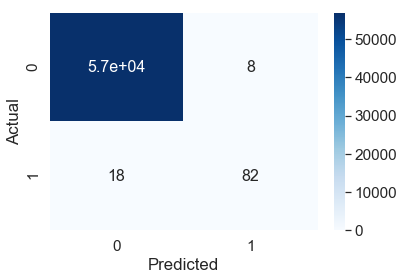

In [186]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

LDA performs much better with only 18 out of cases of fraud not caught. Additionally, False poitives are less as well.
However, there are still 18 fraud cases int he test set which aren't caught. This will be further taken care in the following section.

<a id='5.2'></a>
## 6.2. Model Tuning for balancing the sample by Random Under Sampling
In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

Steps:
1. The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
2. Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.
3. After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 492 non-fraud transaction from 284,315 non-fraud transaction)


In [204]:
Y_train.head()

44828     0
221877    0
278826    0
149792    0
226041    0
Name: Class, dtype: int64

In [121]:
df = dataset.sample(frac=1)


# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
df_new = normal_distributed_df.sample(frac=1, random_state=42)
# split out validation dataset for the end
Y_train_new= df_new["Class"]
X_train_new = df_new.loc[:, dataset.columns != 'Class']

dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.62,0
1,0.0,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.69,0
2,1.0,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.66,0
3,1.0,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.50,0
4,2.0,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.99,0


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


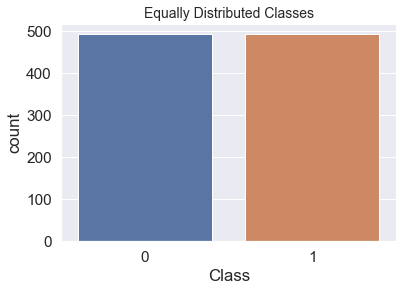

In [99]:
print('Distribution of the Classes in the subsample dataset')
print(df_new['Class'].value_counts()/len(df_new))
sns.countplot('Class', data=df_new)
pyplot.title('Equally Distributed Classes', fontsize=14)
pyplot.show()

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing.
Given the total number of data points are around 900, we try all the Models including Deep Learning Models. 
However, given the data is balanced, the metric used here is accuracy, as it focuses on both false positive and false negative. 

In [189]:
scoring='accuracy'

In [187]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [190]:
#Writing the Deep Learning Classifier in case the Deep Learning Flag is Set to True
#Set the following Flag to 1 if the Deep LEarning Models Flag has to be enabled
EnableDLModelsFlag = 1
if EnableDLModelsFlag == 1 :   
    # Function to create model, required for KerasClassifier
    def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation=activation))
        model.add(Dense(32, activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model    
    models.append(('DNN', KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)))

In [191]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train_new, Y_train_new, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.933931 (0.018942)
LDA: 0.899371 (0.019577)
KNN: 0.660513 (0.039371)
CART: 0.909534 (0.031120)
NB: 0.869852 (0.035162)
SVM: 0.544764 (0.056317)
NN: 0.614863 (0.101394)
AB: 0.931890 (0.026648)
GBM: 0.941012 (0.016439)
RF: 0.929850 (0.018031)
ET: 0.930891 (0.017551)
DNN: 0.497969 (0.050337)
DNN: 0.513265 (0.049018)


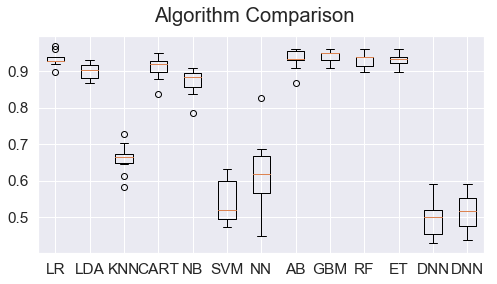

In [192]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

Given that GBM is the best model out of all the models, a grid search is performed for GBM model by varing number of estimators and maximum depth. 

In [146]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180,1000]
max_depth= [2, 3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_new, Y_train_new)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.942073 using {'max_depth': 3, 'n_estimators': 180}
#8 0.929878 (0.019678) with: {'max_depth': 2, 'n_estimators': 20}
#3 0.939024 (0.020977) with: {'max_depth': 2, 'n_estimators': 180}
#6 0.930894 (0.027402) with: {'max_depth': 2, 'n_estimators': 1000}
#6 0.930894 (0.022749) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.942073 (0.015269) with: {'max_depth': 3, 'n_estimators': 180}
#4 0.938008 (0.023539) with: {'max_depth': 3, 'n_estimators': 1000}
#9 0.927846 (0.027504) with: {'max_depth': 5, 'n_estimators': 20}
#5 0.934959 (0.022007) with: {'max_depth': 5, 'n_estimators': 180}
#1 0.942073 (0.024217) with: {'max_depth': 5, 'n_estimators': 1000}


In [194]:
# prepare model
model = GradientBoostingClassifier(max_depth= 3, n_estimators = 180)
model.fit(X_train_new, Y_train_new)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=180,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [205]:
# estimate accuracy on Original validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9609915382184614
[[54640  2222]
 [    0   100]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56862
           1       0.04      1.00      0.08       100

    accuracy                           0.96     56962
   macro avg       0.52      0.98      0.53     56962
weighted avg       1.00      0.96      0.98     56962



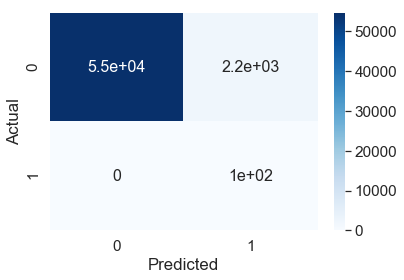

In [198]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

__Conclusion__:

*  Choosing the right metric lead to an enhancement in the fraud cases detected correctly.
* Undersample leads to a significant improvement as all the fraud cases in the test set are correctly identified post undersampling 

* Undersampling came with a tradeoff though. In our undersample data our model is unable to detect for a large number of cases non fraud transactions correctly and instead, misclassifies those non fraud transactions as fraud cases. Imagine that people that were making regular purchases got their card blocked due to the reason that our model classified that transaction as a fraud transaction, this will be a huge disadvantage for the financial institution. 
